# Predicting Fatal Accidents in UK's Public Roads

# Motivation
Road accidents claim thousands of lives and cause several hundred thousands slight to permanent injuries each year in the UK's public roads.There are serious costs associated with traffic accidents including human lives lost, healtcare costs of those injured, economic and psychological costs of lost time due to traffic congestions following accidents to name few among many others. Knowing what factors primarily determine or cause road accidents will help policy-makers design policies to address those factors to prevent or minimize accidents that will save lives and costs associated with accidents.

In this supervised learning capstone, I am building a supervised machine learning model:
* to learn what factors determine the occurrence of fatal accidents in UK's public roads and; 
* evaluate how well the model can predict those accidents based on observed accidents data.

# Data

I use the Road Safety Data from the __[UK Department for Transport](https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data)__. The dataset provides detailed information about road accidents across the public roads in the UK in 2016 that were reported to the police including:
* time and location; 
* vehicles involved; 
* road and weather conditions and: 
* consequential fatalities.

# Import relevant packages

In [1]:
# General 
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

# Features pre-processing and principal component analysis (pca) 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Train-test split
from sklearn.model_selection import train_test_split

# Classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Classifiers ensembling
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# Random resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Other
from time import time
from scipy.stats import ttest_ind

# Ploting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

# Suppressing annoying harmless error
import warnings
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Import data and print info

In [2]:
# Import dataset
df=pd.read_csv('~/Desktop/Thinkful/data/UK_RoadSafety_Accidents_2016.csv')

# Print info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136621 entries, 0 to 136620
Data columns (total 32 columns):
Accident_Index                                 136621 non-null object
Location_Easting_OSGR                          136614 non-null float64
Location_Northing_OSGR                         136614 non-null float64
Longitude                                      136614 non-null float64
Latitude                                       136614 non-null float64
Police_Force                                   136621 non-null int64
Accident_Severity                              136621 non-null int64
Number_of_Vehicles                             136621 non-null int64
Number_of_Casualties                           136621 non-null int64
Date                                           136621 non-null object
Day_of_Week                                    136621 non-null int64
Time                                           136619 non-null object
Local_Authority_(District)                     136

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Examine missing data

In [3]:
print(df.isnull().sum())

Accident_Index                                    0
Location_Easting_OSGR                             7
Location_Northing_OSGR                            7
Longitude                                         7
Latitude                                          7
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                              2
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                      37
Junction_Detail                                   0
Junction_Con

**Notes:**

Missing data does not seem to be a problem here since few variables have fewer than 50 observations missing except for "_LSOA_of_Accident_Location_" variable. Based on the description, this does not seem to be relevant for our modeling purpose. Therefore I am removing this variable.  

In [4]:
# Drop irrelevant column- LSOA_of_Accident_Location- which had over 8000 missing data
df.drop(['LSOA_of_Accident_Location'],axis=1,inplace=True)

In [5]:
# Drop missing data
df=df.dropna(axis=0, how='any')

# Exploratory data analysis 

# Outcome variable of interest: Serious_Accident

The outcome variable of interest for the modeling is the severity of accidents coded as "Serious_Accident": Serious/Fatal (=1) vs. Slight (=0). 

Count of outcome variable: 
 0    113160
1     23415
Name: Serious_Accident, dtype: int64


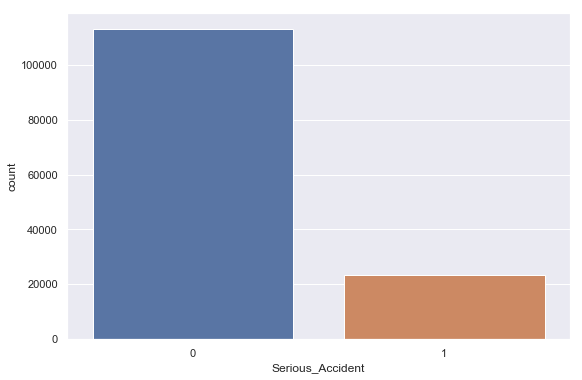

In [6]:
# Define outcome variable- Serious_Accident=1 (Fatal and Serious) and 0(Slight)
df['Serious_Accident']=[1 if i in [1,2] else 0 for i in df['Accident_Severity']]
print('Count of outcome variable: \n', df['Serious_Accident'].value_counts())


# Count plot 
sns.set(style="darkgrid")
plt.figure(figsize=(9,6))
sns.countplot(x = df.Serious_Accident)
plt.show()

# Numerical variables

# Accident location: Latitude

Text(0.5,0,'Latitude')

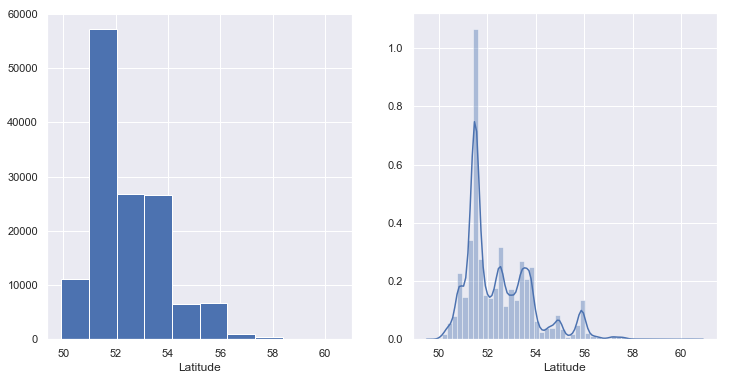

In [7]:
# Set figure style and size
sns.set(style="darkgrid")
plt.figure(figsize=(12,6))

# Latitude
plt.title('Latitude of accident location')
plt.subplot(1, 2, 1)
df['Latitude'].hist()
plt.xlabel('Latitude')

plt.subplot(1, 2, 2)
sns.distplot(df['Latitude'])
plt.xlabel('Latitude')

# Accident location: Longitude

Text(0.5,0,'Longitude')

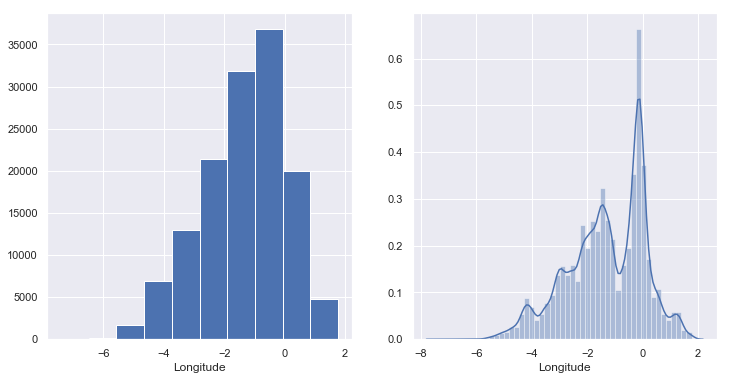

In [8]:
# Set figure style and size
sns.set(style="darkgrid")
plt.figure(figsize=(12,6))

# Latitude
plt.title('Longitude of accident location')
plt.subplot(1, 2, 1)
df['Longitude'].hist()
plt.xlabel('Longitude')

plt.subplot(1, 2, 2)
sns.distplot(df['Longitude'])
plt.xlabel('Longitude')

# Number of vehicles involved

In [9]:
# Count and descriptive statistics
print(df['Number_of_Vehicles'].describe())
print('\n')
print(df.groupby('Number_of_Vehicles')['Accident_Index'].count())
print('\n')

count   136575.000
mean         1.848
std          0.710
min          1.000
25%          1.000
50%          2.000
75%          2.000
max         16.000
Name: Number_of_Vehicles, dtype: float64


Number_of_Vehicles
1     39521
2     82841
3     10959
4      2446
5       517
6       169
7        72
8        26
9        11
10        6
11        4
12        1
13        1
16        1
Name: Accident_Index, dtype: int64




**Notes:**

On average, two vehicles are involved in an accident. Accidents that involve more than 4 vehicles seem to be outliers- under 1000 instances in total. Therefore, I removed these accidents. 

In [10]:
# Remove outliers
df.drop(df[df.Number_of_Vehicles >4].index, inplace=True)

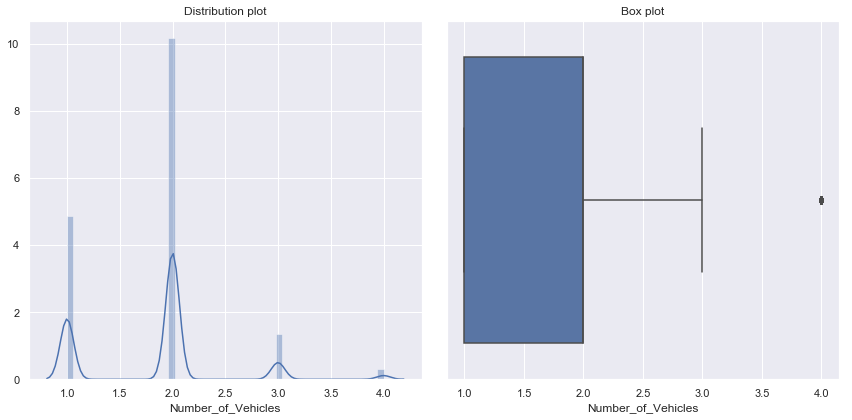

In [11]:
# Distribution plot
sns.set(style="darkgrid")
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.distplot(df['Number_of_Vehicles'])
plt.title('Distribution plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(df['Number_of_Vehicles'])
plt.title('Box plot')
plt.tight_layout()
plt.show()

# Number of casualties

In [12]:
# Count and descriptive statistics
print(df['Number_of_Casualties'].describe())
print('\n')
print(df.groupby('Number_of_Casualties')['Accident_Index'].count())
print('\n')

count   135767.000
mean         1.321
std          0.774
min          1.000
25%          1.000
50%          1.000
75%          1.000
max         58.000
Name: Number_of_Casualties, dtype: float64


Number_of_Casualties
1     106431
2      20365
3       5834
4       2003
5        725
6        242
7         72
8         36
9         17
10        15
11         4
12         6
13         1
14         3
15         3
16         2
18         1
19         2
21         1
23         1
27         2
58         1
Name: Accident_Index, dtype: int64




**Notes:**

On average, there is one casulaty in an accident. Accidents that result in more than 4 casualties  seem to be outliers- little over 1000 instances in total. Therefore, I removed these accidents. 

In [13]:
# Drop outliers
df.drop(df[df.Number_of_Casualties > 4].index, inplace=True)

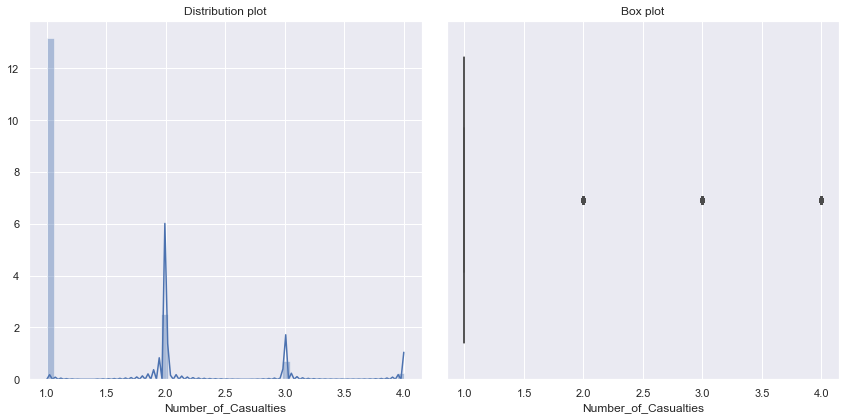

In [14]:
# Distribution plot
sns.set(style="darkgrid")
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.distplot(df['Number_of_Casualties'])
plt.title('Distribution plot')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(df['Number_of_Casualties'])
plt.title('Box plot')
plt.tight_layout()
plt.show()

# Number of vehicles and casualties by severity of accidents

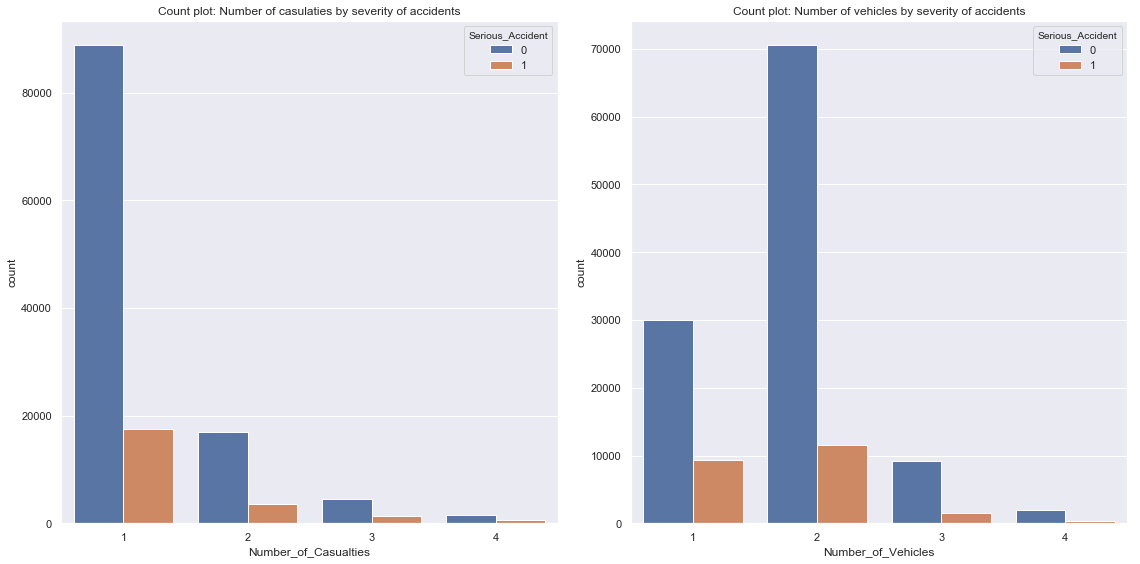

In [15]:
# Number of casualties by the severity of accidents
sns.set(style="darkgrid")
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
sns.countplot(hue="Serious_Accident", x="Number_of_Casualties", data=df)
plt.title('Count plot: Number of casulaties by severity of accidents')

# Number of vehicles by the severity of accidents
plt.subplot(1, 2, 2)
sns.countplot(hue="Serious_Accident", x="Number_of_Vehicles", data=df)
plt.title('Count plot: Number of vehicles by severity of accidents')

plt.tight_layout()
plt.show()

# Categorical variables

In [16]:
# Define a functin to perform a chi-squared test of independence
def chi_sq_test(col1, col2):
    counttable=pd.crosstab(df[col1], df[col2])
    print(counttable)
    print(stats.chisquare(counttable, axis=None))

In [17]:
# Define a function to print countplots
def count_plot(col1):
    sns.set(style="darkgrid")
    plt.figure(figsize=(12,6))
    sns.countplot(x = df[col1], hue="Serious_Accident", data=df)
    plt.tight_layout()

# Day of week 

* Although serious accidents did not seem to vary across the days of week, slight accidents peaked on Fridays with lowest on Sundays. 

Chi-squared test of independence between days of week and severity of accidents


Day_of_Week       Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
Serious_Accident                                                        
0                  18544   15958     14295   11756     17356    16603   
1                   3700    3077      3199    2977      3312     3254   

Day_of_Week       Wednesday  
Serious_Accident             
0                     17266  
1                      3336  
Power_divergenceResult(statistic=62008.82242095178, pvalue=0.0)


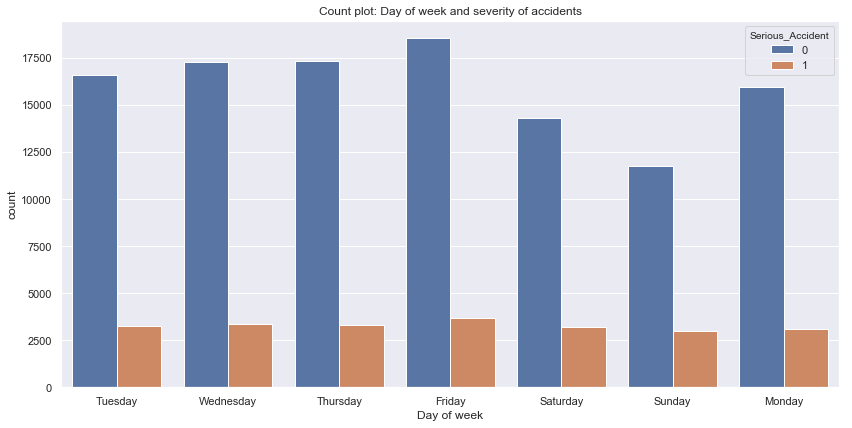

In [18]:
# Day of week
df['Day_of_Week']=['Sunday' if i in [1] else 'Monday' if i in [2] else 'Tuesday' if i in [3] else 'Wednesday'
                   if i in [4] else 'Thursday' if i in [5] else 'Friday' if i in [6] else 'Saturday'
                   for i in df['Day_of_Week']]

# Count plot  
count_plot('Day_of_Week')
plt.xlabel('Day of week')
plt.title('Count plot: Day of week and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between days of week and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Day_of_Week')

# Month of year

* Serious or slight accidents are more or less equally distributed across the months of year with slightly fewer accidents in winter months of December, February and March.

Chi-squared test of independence between months of year and severity of accidents


month              Apr   Aug   Dec   Feb   Jan   Jul   Jun   Mar   May    Nov  \
Serious_Accident                                                                
0                 9183  9577  8868  8554  9835  9589  9162  8714  9327  10140   
1                 1769  1997  1856  1623  1882  2107  1803  1820  1989   2034   

month              Oct   Sep  
Serious_Accident              
0                 9328  9501  
1                 1960  2015  
Power_divergenceResult(statistic=59180.993953934034, pvalue=0.0)


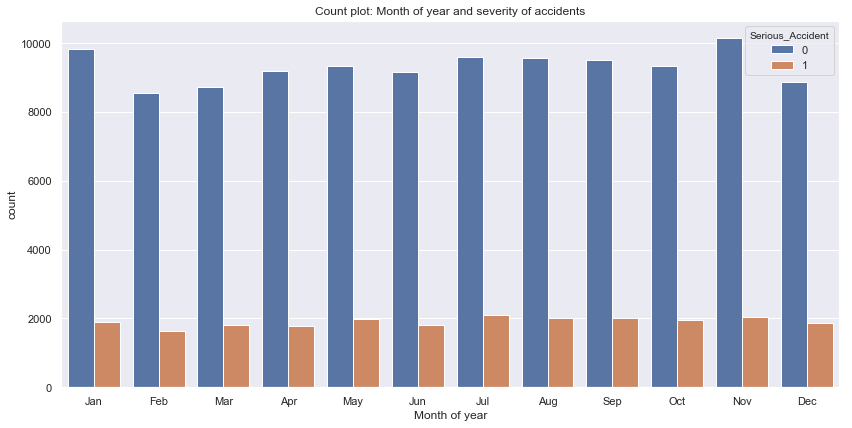

In [19]:
# Split date into month
df['month']=pd.DatetimeIndex(df['Date']).month

# Month of year
df['month']=['Jan' if i in [1] else 'Feb' if i in [2] else 'Mar' if i in [3] else 'Apr'if i in [4] else 'May' 
             if i in [5] else 'Jun' if i in [6] else 'Jul' if i in [7] else 'Aug' if i in [8] else 'Sep' if i in [9]
             else 'Oct' if i in [10] else 'Nov' if i in [11] else 'Dec' for i in df['month']]

# Count plot  
count_plot('month')
plt.xlabel('Month of year')
plt.title('Count plot: Month of year and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between months of year and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','month')

# Day of month

* There is some variation on both slight and serious accidents across the days of month reaching the lowest on the 31st. 

Chi-squared test of independence between days of month and severity of accidents


day                 D1   D10   D11   D12   D13   D14   D15   D16   D17   D18  \
Serious_Accident                                                               
0                 3492  3826  4253  4125  3786  3768  3902  3879  3510  3689   
1                  671   831   829   787   819   810   836   787   719   708   

day               ...    D29    D3   D30   D31    D4    D5    D6    D7    D8  \
Serious_Accident  ...                                                          
0                 ...   3763  3810  3231  1836  3248  3784  3490  3628  3611   
1                 ...    766   678   661   433   624   775   762   820   808   

day                 D9  
Serious_Accident        
0                 3613  
1                  816  

[2 rows x 31 columns]
Power_divergenceResult(statistic=61107.38728989178, pvalue=0.0)


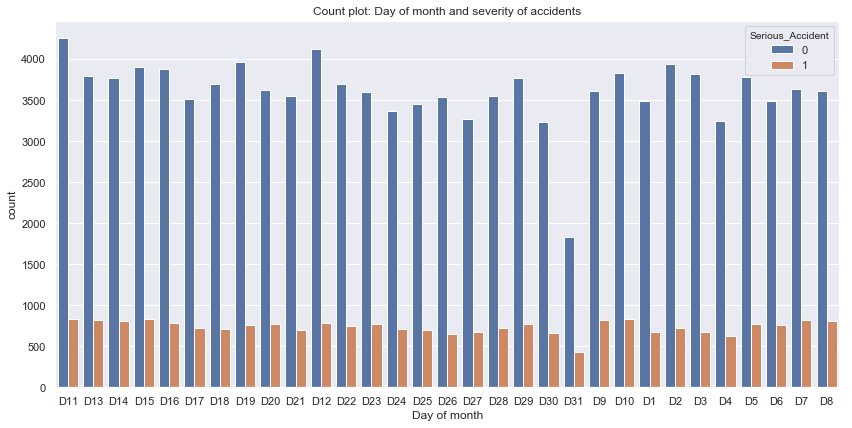

In [20]:
# Split day from date
df['day']=pd.DatetimeIndex(df['Date']).day

# Day of month
df['day']=['D1' if i in [1] else 'D2' if i in [2] else 'D3' if i in [3] else 'D4'if i in [4] else 'D5' 
             if i in [5] else 'D6' if i in [6] else 'D7' if i in [7] else 'D8' if i in [8] else 'D9' if i in [9]
             else 'D10' if i in [10] else 'D11' if i in [11] else 'D12' if i in [12] else 'D13' if i in [13] else 'D14' 
             if i in [14] else 'D15' if i in [15] else 'D16'if i in [16] else 'D17' if i in [17] else 'D18' if i in 
             [18] else 'D19' if i in [19] else 'D20' if i in [20] else 'D21' if i in [21] else 'D22' if i in [22] 
             else 'D23' if i in [23] else 'D24' if i in [24] else 'D25' if i in [25] else 'D26' if i in [26] else 'D27'
             if i in [27] else 'D28'if i in [28] else 'D29' if i in [29] else 'D30' if i in [30] else 'D31'
           for i in df['day']]

# Count plot  
count_plot('day')
plt.xlabel('Day of month')
plt.title('Count plot: Day of month and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between days of month and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','day')

# Hour of day

* As expected, there are fewer accidents in the early hours after midnight with multiple peaks at 8 am in the morning and 5 and 6 pm in the evening when most people drive to and from office.

Chi-squared test of independence between hours of day and severity of accidents


hour                H0    H1   H10   H11   H12   H13   H14   H15   H16   H17  \
Serious_Accident                                                               
0                 1499  1085  5246  5717  6470  6552  6934  8624  9088  9948   
1                  408   343  1037  1124  1208  1366  1349  1655  1811  1938   

hour              ...    H21   H22   H23   H3   H4   H5    H6    H7    H8  \
Serious_Accident  ...                                                       
0                 ...   3282  2774  2087  677  575  927  2260  5201  8517   
1                 ...    777   684   504  237  188  293   567  1011  1330   

hour                H9  
Serious_Accident        
0                 5587  
1                  948  

[2 rows x 24 columns]
Power_divergenceResult(statistic=135149.62399263182, pvalue=0.0)


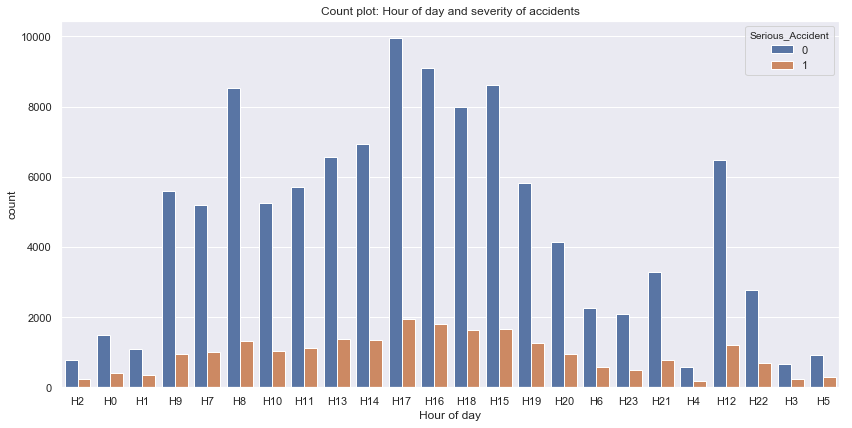

In [21]:
# Hour of day dummies
df['hour']=pd.DatetimeIndex(df['Time']).hour

# Day of month
df['hour']=['H1' if i in [1] else 'H2' if i in [2] else 'H3' if i in [3] else 'H4'if i in [4] else 'H5' 
             if i in [5] else 'H6' if i in [6] else 'H7' if i in [7] else 'H8' if i in [8] else 'H9' if i in [9]
             else 'H10' if i in [10] else 'H11' if i in [11] else 'H12' if i in [12] else 'H13' if i in [13]
            else 'H14' if i in [14] else 'H15' if i in [15] else 'H16' if i in [16] else 'H17' if i in [17]
            else 'H18' if i in [18] else 'H19' if i in [19] else 'H20' if i in [20] else 'H21' if i in [21]
            else 'H22' if i in [22] else 'H23' if i in [23] else 'H0' for i in df['hour']]

# Count plot  
count_plot('hour')
plt.xlabel('Hour of day')
plt.title('Count plot: Hour of day and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between hours of day and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','hour')

# First road class

* Majority of accidents happened on class A roads which are primary route network roads in UK followed by unclassified roads.  

Chi-squared test of independence between first road classes and severity of accidents


1st_Road_Class    Class A  Class B  Class C  Unclassified
Serious_Accident                                         
0                   54731    13293     7703         36051
1                   10852     3115     1584          7304
Power_divergenceResult(statistic=145507.74534475204, pvalue=0.0)


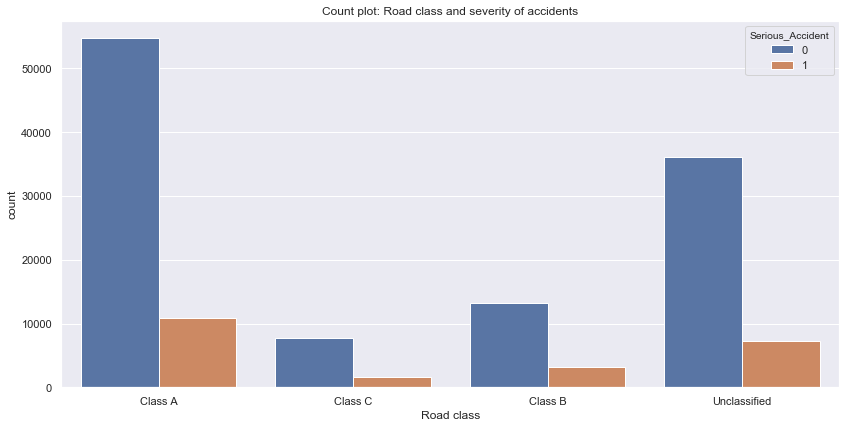

In [22]:
# Road class 
df['1st_Road_Class']=['Class A' if i in [1,2,3] else 'Class B' if i in [4] else 'Class C' if i in [5] else
                      'Unclassified' for i in df['1st_Road_Class']]

# Count plot  
count_plot('1st_Road_Class')
plt.xlabel('Road class')
plt.title('Count plot: Road class and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between first road classes and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','1st_Road_Class')

# Road type

* Majority of accidents happened on the single carriageway roads.

Chi-squared test of independence between road types and severity of accidents


Road_Type         DualCarriageway  RoadType_Other  SingleCarriageWay
Serious_Accident                                                    
0                           16472           12820              82486
1                            3017            1840              17998
Power_divergenceResult(statistic=202997.53365816706, pvalue=0.0)


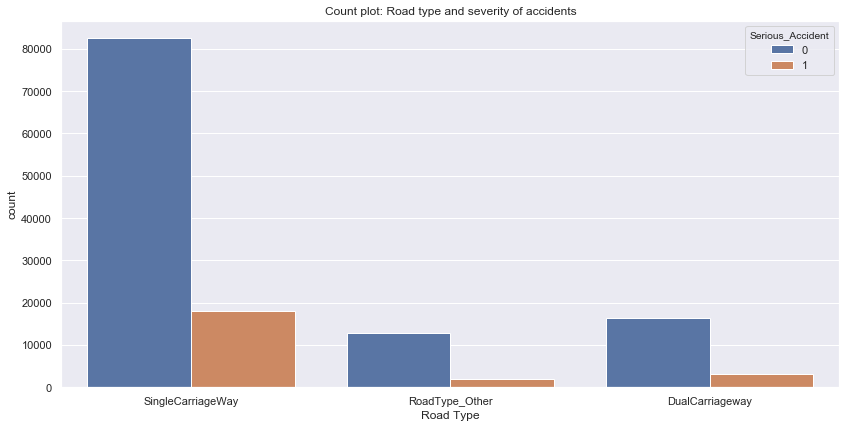

In [23]:
# Drop missing coded as -1
df.drop(df[df.Road_Type == -1].index, inplace=True)

# Road Type
df['Road_Type']=['SingleCarriageWay' if i in [6] else 'DualCarriageway' if i in [3] else 'RoadType_Other'
                       for i in df['Road_Type']]

# Count plot  
count_plot('Road_Type')
plt.xlabel('Road Type')
plt.title('Count plot: Road type and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between road types and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Road_Type')

# Speed limit

* Most of the accidents happend on roads with the speed limit of 30 mph.

Chi-squared test of independence between road types and severity of accidents


Speed_limit       SpeedLimit20  SpeedLimit30  SpeedLimit40  SpeedLimit50  \
Serious_Accident                                                           
0                         5690         71631          9262          4441   
1                         1021         12637          1993          1114   

Speed_limit       SpeedLimit60  SpeedLimit70  
Serious_Accident                              
0                        13383          7371  
1                         4594          1496  
Power_divergenceResult(statistic=372667.1558013267, pvalue=0.0)


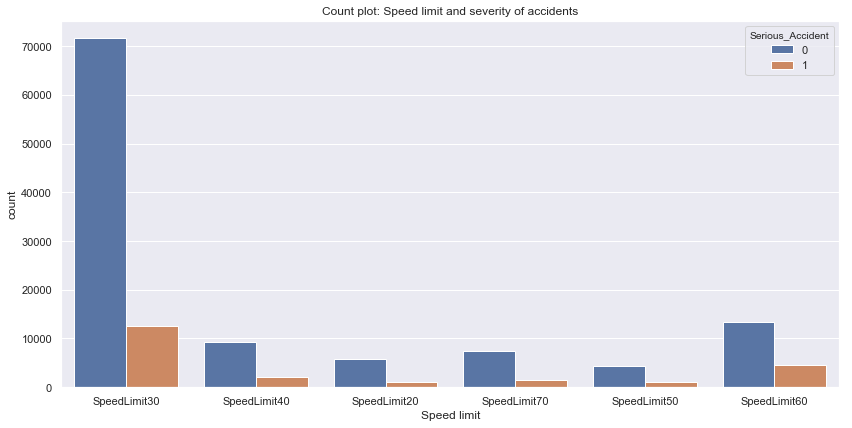

In [24]:
# Speed limit
df['Speed_limit']=['SpeedLimit20' if i in [20.000] else 'SpeedLimit30' if i in [30.000] else 'SpeedLimit40' if i in 
                   [40.000] else 'SpeedLimit50' if i in [50.000] else 'SpeedLimit60' if i in [60.000] else 
                   'SpeedLimit70' for i in df['Speed_limit']]

# Count plot  
count_plot('Speed_limit')
plt.xlabel('Speed limit')
plt.title('Count plot: Speed limit and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between road types and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Speed_limit')

# Road junction

* A larger number of accidents happened not at junctions or within 20 m of junctions followed by T junctions. 

Chi-squared test of independence between road junctions and severity of accidents


Junction_Detail   Junction_Crossroads  Junction_Roundabout  Junction_T  \
Serious_Accident                                                         
0                               11204                11763       35541   
1                                1836                 1577        6831   

Junction_Detail   NotAt_Junc_OrWithin20m  Other_Junction  
Serious_Accident                                          
0                                  44335            8935  
1                                  10888            1723  
Power_divergenceResult(statistic=143643.83963069975, pvalue=0.0)


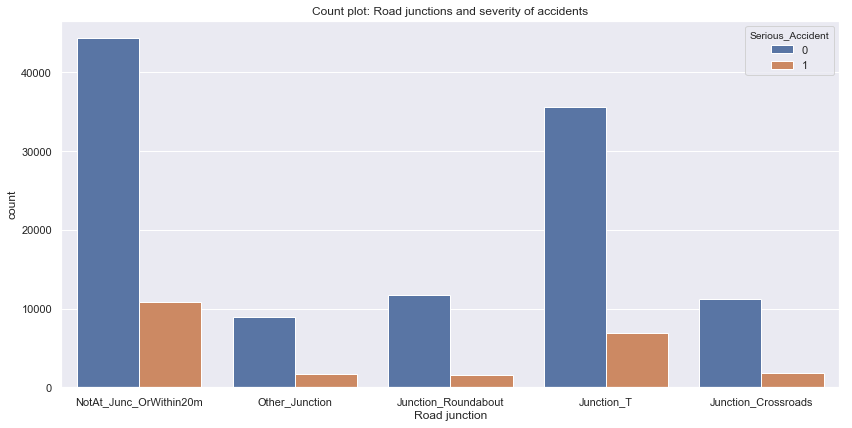

In [25]:
# Road junction
df['Junction_Detail']=['NotAt_Junc_OrWithin20m' if i in [0] else 'Junction_Roundabout' if i in [1,2] else 'Junction_T'
                       if i in [3] else 'Junction_Crossroads' if i in [6] else 'Other_Junction' for i in df['Junction_Detail']]

# Count plot  
count_plot('Junction_Detail')
plt.xlabel('Road junction')
plt.title('Count plot: Road junctions and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between road junctions and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Junction_Detail')

# Pedestrian crossing - physical facilities

* Majority of accident locations did not have any pedestrian crossings or physical facilites.

Chi-squared test of independence between pedestrian physical crossing facilities and severity of accidents


PedCross_PhysFacs  No_PedCross_PhysFacs  Other_PedPhyFacs  Ped_TrafficSignal
Serious_Accident                                                            
0                                 89699             13289               8790
1                                 18997              2586               1272
Power_divergenceResult(statistic=251704.537349684, pvalue=0.0)


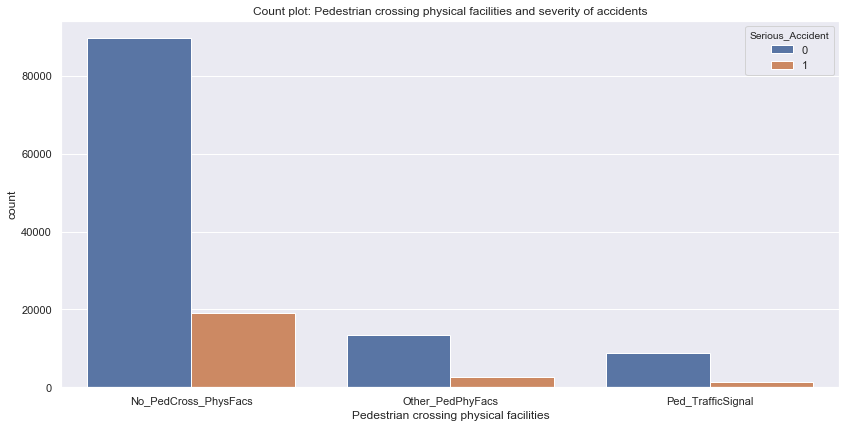

In [26]:
# Pedestrian_Crossing-Physical_Facilities
df['PedCross_PhysFacs']=['No_PedCross_PhysFacs' if i in [0] else 'Ped_TrafficSignal' if i in [5] else 
                         'Other_PedPhyFacs' for i in df['Pedestrian_Crossing-Physical_Facilities']]

# Count plot  
count_plot('PedCross_PhysFacs')
plt.xlabel('Pedestrian crossing physical facilities')
plt.title('Count plot: Pedestrian crossing physical facilities and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between pedestrian physical crossing facilities and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','PedCross_PhysFacs')

# Light conditions

* Majority of accidents happened during the day light hours.

Chi-squared test of independence between road light conditions and severity of accidents


Light_Conditions  Dark_LightsLit  Daylight  Other_LightConditions
Serious_Accident                                                 
0                          22385     81828                   7565
1                           4775     15793                   2287
Power_divergenceResult(statistic=201016.7534928287, pvalue=0.0)


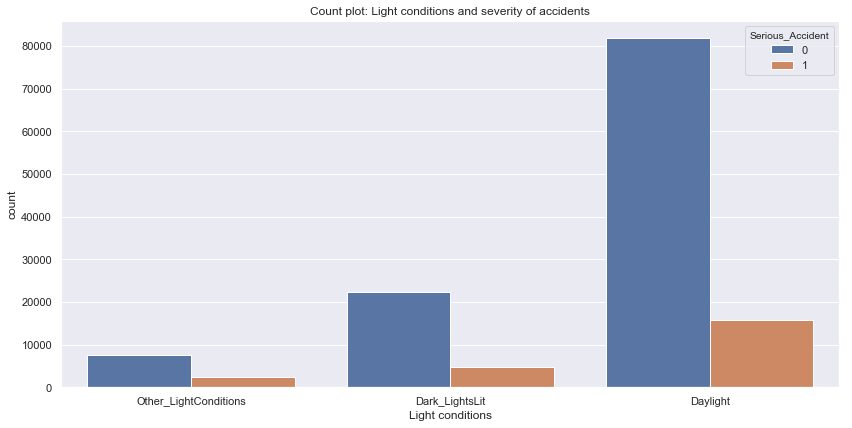

In [27]:
# Light conditions
df['Light_Conditions']=['Daylight' if i in [1] else 'Dark_LightsLit' if i in [4] else 'Other_LightConditions' for i in 
                        df['Light_Conditions']]

# Count plot  
count_plot('Light_Conditions')
plt.xlabel('Light conditions')
plt.title('Count plot: Light conditions and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between road light conditions and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Light_Conditions')

# Road surface conditions

* Majority of accidents happened on dry roads followed by wet or flooded roads.

Chi-squared test of independence between road surface conditions and severity of accidents


Road_Surface_Conditions  Other_RoadSurfaceConditions  Road_Dry  Road_WetFlood
Serious_Accident                                                             
0                                               1906     81318          27858
1                                                333     16498           5958
Power_divergenceResult(statistic=211242.31569944203, pvalue=0.0)


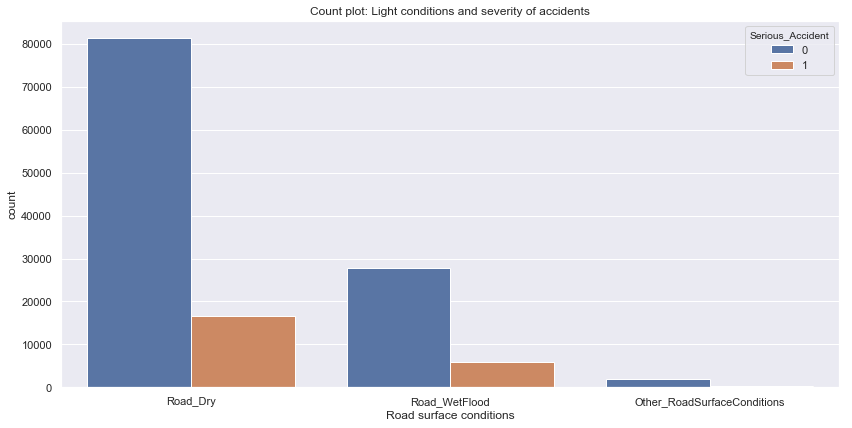

In [28]:
# Drop missing data coded as -1
df.drop(df[df.Road_Surface_Conditions == -1].index, inplace=True)

# Light conditions
df['Road_Surface_Conditions']=['Road_Dry' if i in [1] else 'Road_WetFlood' if i in [2,5] else 
                               'Other_RoadSurfaceConditions' for i in df['Road_Surface_Conditions']]

# Count plot  
count_plot('Road_Surface_Conditions')
plt.xlabel('Road surface conditions')
plt.title('Count plot: Light conditions and severity of accidents')

# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between road surface conditions and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Road_Surface_Conditions')

# Urban rural classification of accident location

* Maority of accidents happened in urban locations.

Chi-squared test of independence between rural/urban and severity of accidents


Urban                 0      1
Serious_Accident              
0                 36941  74141
1                 10001  12788
Power_divergenceResult(statistic=79022.85474075789, pvalue=0.0)


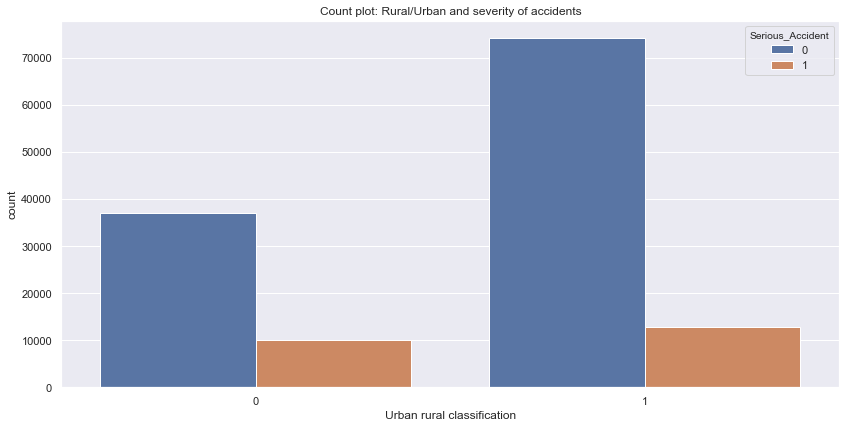

In [29]:
# Urban
df['Urban']=[1 if i in [1] else 0 for i in df['Urban_or_Rural_Area']]

# Plot
count_plot('Urban')
plt.xlabel('Urban rural classification')
plt.title('Count plot: Rural/Urban and severity of accidents')


# Table of counts and chi-squared test of independence
print('Chi-squared test of independence between rural/urban and severity of accidents')
print('\n')
chi_sq_test('Serious_Accident','Urban')

# Feature engineering

In [30]:
# Convert categirical variables into present/absent or dummy variables
df=pd.get_dummies(df, columns=['Day_of_Week', 'month', 'day', 'hour', '1st_Road_Class', 'Road_Type', 
                                       'Speed_limit','Junction_Detail', 'PedCross_PhysFacs', 'Light_Conditions',
                                       'Road_Surface_Conditions'])

# Keep only relevant variables

In [31]:
# Keep relevant df features only
df.drop(['Accident_Index','Location_Easting_OSGR', 'Location_Northing_OSGR', 'Police_Force', 'Accident_Severity',
         'Date','Time','Local_Authority_(District)','Local_Authority_(Highway)','1st_Road_Number',
         'Junction_Control', '2nd_Road_Class','2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
         'Pedestrian_Crossing-Physical_Facilities','Special_Conditions_at_Site','Carriageway_Hazards',
         'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident','Weather_Conditions'],
        axis=1,inplace=True)

In [32]:
df.shape

(133871, 107)

# Heatmap of correlation matrix

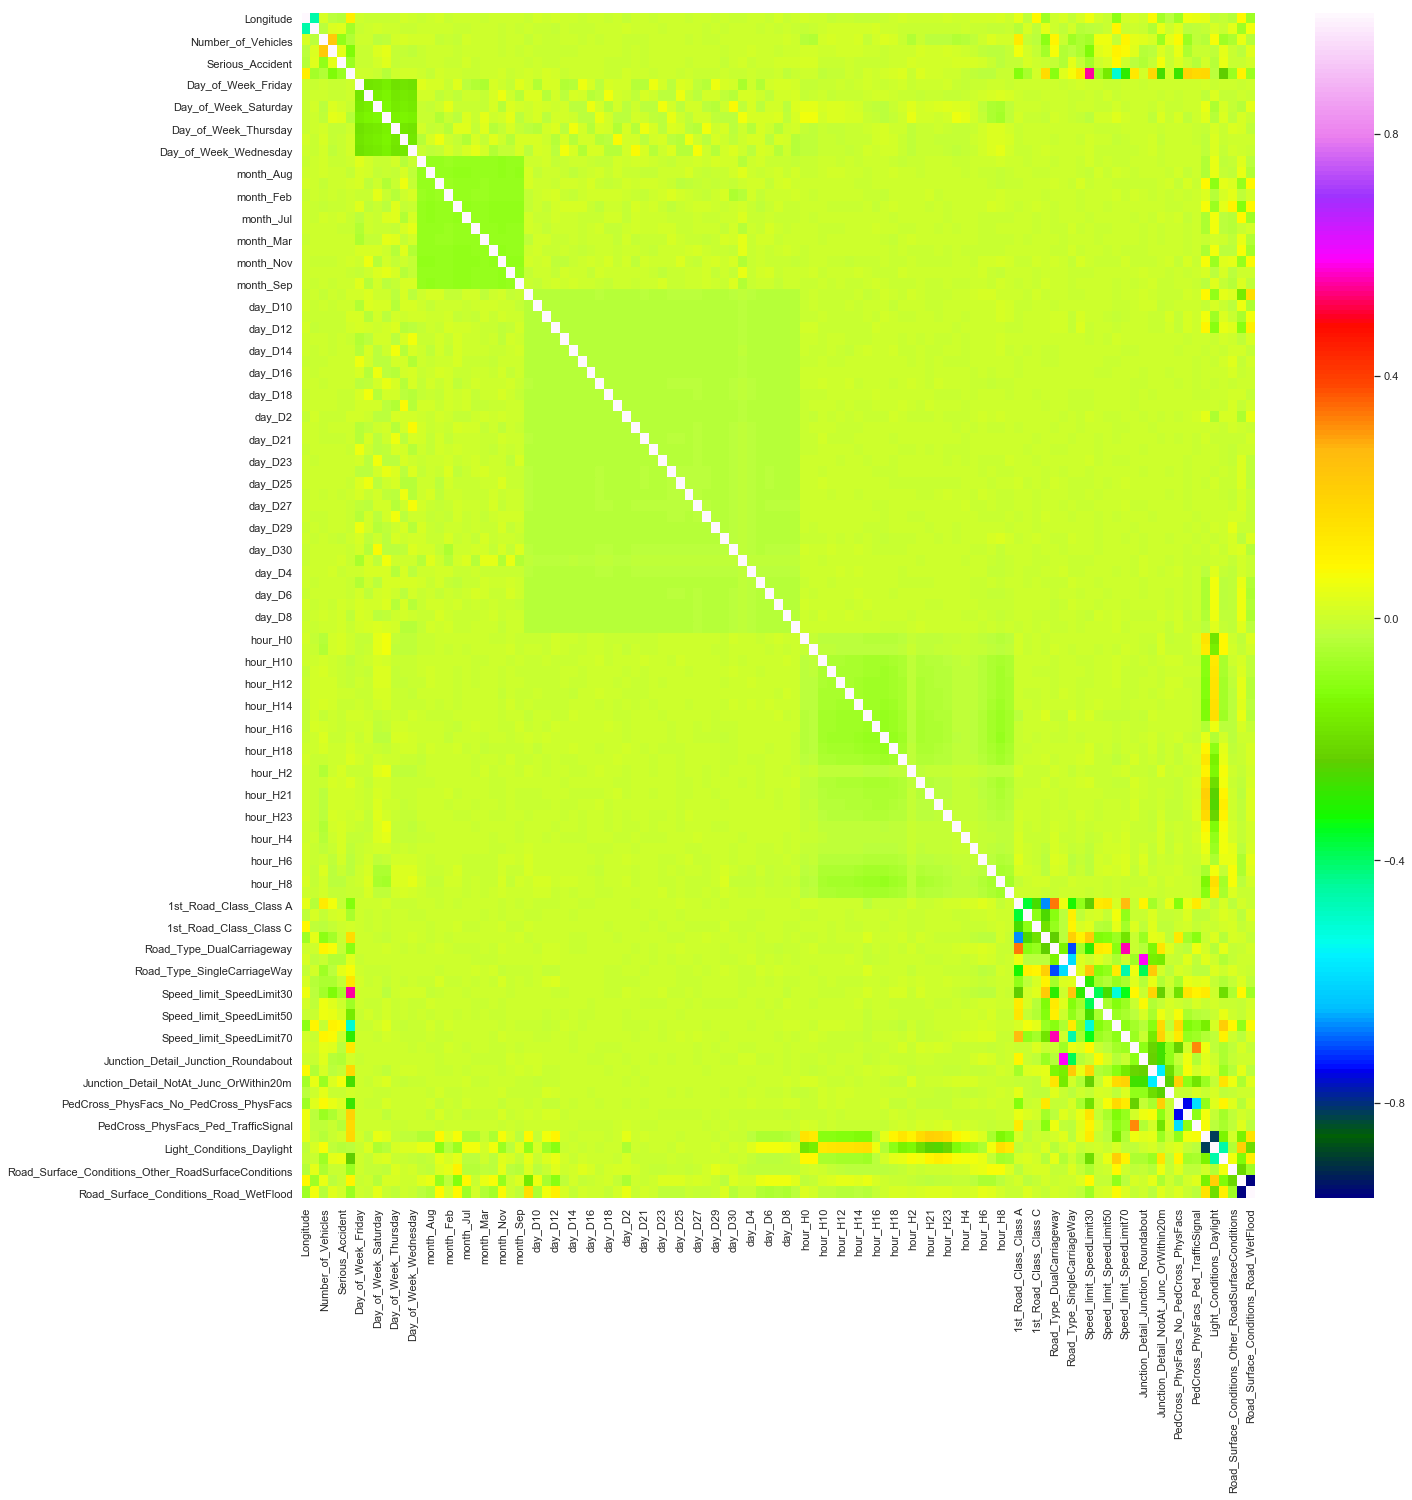

In [33]:
# Correlation heatmap
plt.figure(figsize=(21,21))
sns.color_palette("hls", 8)
sns.heatmap(df.corr(), cmap='gist_ncar')
plt.tight_layout()

# Seperate dataframe into outcome (y) and features (x)

In [34]:
# Seperate outcome (y) and features (x)
y=df.loc[:,'Serious_Accident']
x=df.loc[:, df.columns != 'Serious_Accident']
print('Shape of y: \n', y.shape[0])
print('Shape of x: \n', x.shape)

Shape of y: 
 133871
Shape of x: 
 (133871, 106)


# Feature selection

# Principal component analysis

In [35]:
# Standardizing the features
x_stand = StandardScaler().fit_transform(x)

# PCA to keep 95% of variance
pca = PCA(0.95)

# Components required to keep 95% of variance
x_pca = pca.fit_transform(x_stand)

# Cumulative sum of explained variance by the components
var_cumsum=pca.explained_variance_ratio_.cumsum()
print(var_cumsum)
print('\n')
print('Need to keep {} components to explain 95% of the variance.'.format(len(var_cumsum)))

[0.03323327 0.06089765 0.08743688 0.10588522 0.12369434 0.13900625
 0.15368644 0.167574   0.18085961 0.19405919 0.20683686 0.21935747
 0.23171434 0.24374717 0.25550529 0.26700076 0.27834447 0.2893343
 0.30024209 0.31096358 0.32167232 0.33236673 0.34300807 0.3535615
 0.36403603 0.37448474 0.38491932 0.39532574 0.40571686 0.41603052
 0.42630975 0.4365717  0.44680058 0.45697863 0.46711491 0.47720349
 0.48727296 0.49730562 0.50732317 0.51733347 0.52732699 0.53730884
 0.54727708 0.55721645 0.56709085 0.57693454 0.58676887 0.59654975
 0.60632496 0.61609804 0.62585418 0.63560607 0.64534894 0.65508279
 0.66479668 0.67450453 0.68419468 0.69387781 0.70354097 0.71319216
 0.72283177 0.73245316 0.74205172 0.7516402  0.76122262 0.77076706
 0.78030183 0.78982687 0.79933247 0.80880239 0.81826424 0.82770157
 0.83708677 0.84643024 0.8557341  0.8649866  0.87420653 0.88339625
 0.89242533 0.90133651 0.91020649 0.91873065 0.92706236 0.93521392
 0.94313588 0.9509212 ]


Need to keep 86 components to explain 

<Figure size 432x432 with 0 Axes>

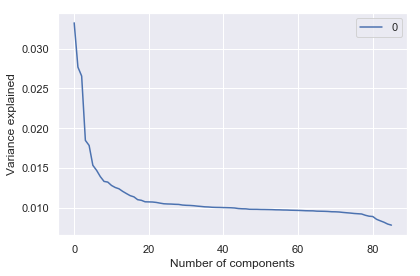

In [36]:
# Scree plot
plt.figure(figsize=(6,6))
pd.DataFrame(list(pca.explained_variance_ratio_)).plot(kind='line')
plt.xlabel('Number of components')
plt.ylabel('Variance explained')

plt.tight_layout()
plt.show()

**Notes:**

* To retain 95% of the variance, I need to keep 84 features which is not much reduction in dimensionality from 98 original features. Therefore, I will use k best feature selection.
* Also, I will evaluate baseline performance of classifiers using these components and k best features. If I dont find much improvement by using these components, it makes sense to use k best features for tuning hyperparameters and using ensemble models for computational and results interpretation reasons.

# K best features

In [37]:
# Select k best features
x_kbest = x[x.columns[SelectKBest(f_classif, k=15).fit(x, y).get_support()]]
print('{} K best features: \n'.format(x_kbest.columns))
print('Shape: ', x_kbest.shape)

Index(['Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Urban', 'Day_of_Week_Sunday', 'Road_Type_RoadType_Other',
       'Road_Type_SingleCarriageWay', 'Speed_limit_SpeedLimit30',
       'Speed_limit_SpeedLimit60', 'Junction_Detail_Junction_Roundabout',
       'Junction_Detail_NotAt_Junc_OrWithin20m',
       'PedCross_PhysFacs_Ped_TrafficSignal', 'Light_Conditions_Daylight',
       'Light_Conditions_Other_LightConditions'],
      dtype='object') K best features: 

Shape:  (133871, 15)


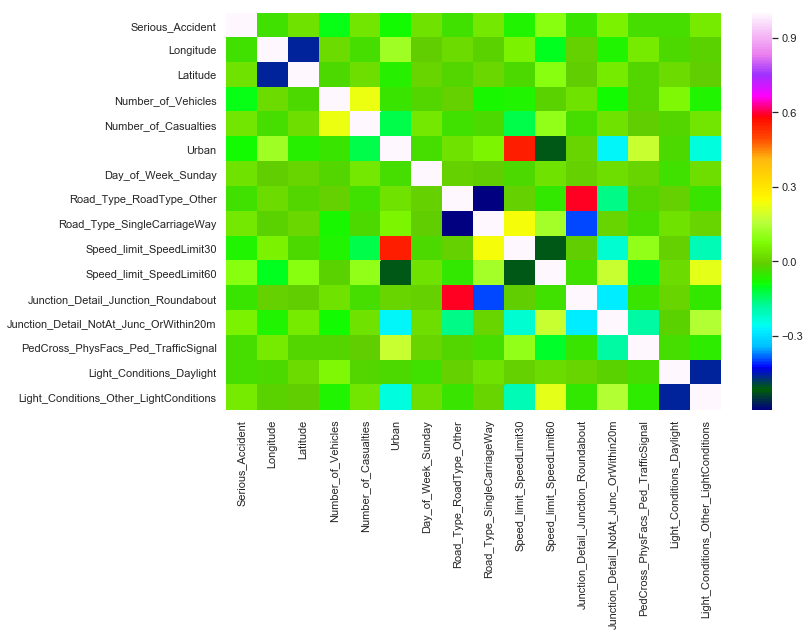

In [38]:
# Heatmap with k best features
df_kbest=pd.concat([y, x_kbest], axis=1)
plt.figure(figsize=(12,9))
sns.heatmap(df_kbest.corr(), cmap='gist_ncar')
plt.tight_layout()

# Final samples

In [39]:
# Final samples
print('Number of samples: ', df.shape[0])
print('\n')
print('Proportion of positive outcomes: ', round(df['Serious_Accident'].mean(),2))

Number of samples:  133871


Proportion of positive outcomes:  0.17


**Notes:**

* The final sample is an imbalanced sample since the percentage of positive outcomes or fatal/serious accidents is only 17%. I use random under sampling of majority class (i.e., slight accidents) resmapling technique to achieve the balanced samples and use this for the classification modeling below. 

# Split train and test samples

In [40]:
# Split samples into train (80%) and test (20%) samples
X_train, X_test, y_train, y_test = train_test_split(x_kbest, y, test_size=0.2, random_state=321)
print('Train samples: ', X_train.shape)
print('Test samples: ', X_test.shape)

Train samples:  (107096, 15)
Test samples:  (26775, 15)


# Random under sampling of majority class 

In [41]:
# Random under sampling of majority class 
X_train_rus, y_train_rus, idx = RandomUnderSampler(random_state=321, return_indices=True).fit_sample(X_train, y_train)
print('Random under sampling {}\n'.format(Counter(y_train_rus)))

Random under sampling Counter({0: 18324, 1: 18324})



# Helper function to fit, predict and evaluate classifier

In [52]:
# Define a function to fit, predict and then print outputs
def fit_eval_clf(model):
    #Fit the model in train samples
    prediction=model.fit(X_train_rus, y_train_rus).predict(X_test)
    
    # Cross-validated accuracy score
    accu_train = cross_val_score(model, X_train_rus, y_train_rus, cv=10, scoring='accuracy')
    print ("Cross-validated accuracy score on train samples: %.3f (+/- %.3f)" %(accu_train.mean(), 
                                                                                accu_train.std()*2))
    
    # Cros-validated area under ROC curve 
    au_roc_train = cross_val_score(model, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
    print ("Cross-validated area under ROC curve on train samples: %.3f (+/- %.3f)" %(au_roc_train.mean(), 
                                                                                      au_roc_train.std()*2))
    print('\n')
    # Accuracy score on test samples
    print ("Accuracy score on test samples: ", round(accuracy_score (y_test, prediction), 2))
    
    # Area under ROC on test samples
    print ("Area under ROC curve on test samples: ", round(roc_auc_score (y_test, prediction), 2))
    

# Helper function to perform RandomizedSearchCV and print best parameters

In [53]:
def rand_search_cv(model, params):
    # Tune the hyperparameters via a randomized search
    rgrid = RandomizedSearchCV(model, params, random_state=321, scoring='roc_auc')
    rgrid.fit(X_train_rus, y_train_rus)
    print("Randomized search took %.2f minutes."% ((time() - start)/60))
    print('Best hyperparameters: ', rgrid.best_params_)

# Classifiers: Baseline performance 

# K-Nearest Neighbors (KNN) Classifier

In [54]:
start=time()
print('KNN Classifier: Baseline performance\n')
fit_eval_clf(KNeighborsClassifier(n_jobs=-1))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

KNN Classifier: Baseline performance

Cross-validated accuracy score on train samples: 0.563 (+/- 0.012)
Cross-validated area under ROC curve on train samples: 0.582 (+/- 0.022)


Accuracy score on test samples:  0.57
Area under ROC curve score on test samples:  0.57


Total time to run: 0.17 minutes.


# Support Vector Classifier

In [ ]:
start=time()
print('Support Vector: Baseline performance\n')
fit_eval_clf(SVC(random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

# Logistic Regression

In [56]:
start=time()
print('Logistic Regression: Baseline performance\n')
fit_eval_clf(LogisticRegression(random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

Logistic Regression: Baseline performance

Cross-validated accuracy score on train samples: 0.595 (+/- 0.011)
Cross-validated area under ROC curve on train samples: 0.624 (+/- 0.012)


Accuracy score on test samples:  0.6
Area under ROC curve score on test samples:  0.6


Total time to run: 0.03 minutes.


# Random Forest

In [57]:
start=time()
print('Random Forest: Baseline performance\n')
fit_eval_clf(RandomForestClassifier(n_jobs=-1,random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

Random Forest: Baseline performance

Cross-validated accuracy score on train samples: 0.564 (+/- 0.017)
Cross-validated area under ROC curve on train samples: 0.584 (+/- 0.021)


Accuracy score on test samples:  0.6
Area under ROC curve score on test samples:  0.57


Total time to run: 0.13 minutes.


# Classifiers: Tune hyperparameters

# K-Nearest Neighbors (KNN) Classifier

In [103]:
start=time()
# Construct the set of hyperparameters to tune
params = {'n_neighbors':[5,6,7],
          'leaf_size':[1,2,3],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree']}

rand_search_cv(KNeighborsClassifier(), params)

Randomized search took 5.74 minutes.
Best hyperparameters:  {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 1, 'algorithm': 'ball_tree'}


In [107]:
start=time()
print('KNN Classifier: Performance after tuning hyperparameters\n')
fit_eval_clf(KNeighborsClassifier(weights='uniform', n_neighbors=10, leaf_size=1, algorithm='ball_tree',n_jobs=-1))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

KNN Classifier: Performance after tuning hyperparameters

Cross-validated accuracy score: 0.826 (+/- 0.005)
Cross-validated area under ROC curve: 0.585 (+/- 0.023)


Total time to run: 0.60 minutes.


# Tune Support Vector

In [240]:
start=time()
# Construct the set of hyperparameters to tune
params = {'C': [6,8,10,12], 
          'kernel': ['linear','rbf']}

rand_search_cv(SVC(), params)

Randomized search took 431.65 minutes.


In [241]:
print('Best hyperparameters: ', svc_rgrid.best_params_)

Best hyperparameters:  {'kernel': 'rbf', 'C': 12}


In [246]:
start=time()
print('Support Vector: Performance after tuning hyperparameters\n')
fit_eval_clf(SVC(kernel= 'rbf', C= 12, random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

Support Vector: Performance after tuning hyperparameters 

CV Accuracy Score on Train Samples: 0.603 (+/- 0.018)
CV Accuracy Score on Test Samples: 0.829 (+/- 0.001)
CV Area Under ROC Curve on Test Samples: 0.546 (+/- 0.029)


Total time to run: 131.79 minutes.


# Tune Random Forest

In [242]:
start=time()
# Construct the set of hyperparameters to tune
params = {'max_depth': [ 10, 15, 20, 30, 40],
          'min_samples_leaf': [1, 3, 4, 7],
          'min_samples_split': [2, 5, 7, 9],
          'n_estimators': [100, 500, 750, 1000, 1500]}

rand_search_cv(RandomForestClassifier(), params, n_iter = 20, cv = 5, verbose=2, n_jobs = -1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40 
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40 
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40 
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40, total= 1.8min
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40, total= 1.8min
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40 
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=3, max_depth=10 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40, total= 1.8min
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=3, max_depth=10 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=1, max_depth=40, total= 1.9min
[CV] n_es

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.7min


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_depth=10, total=   3.6s
[CV] n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_depth=10, total=   3.5s
[CV] n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30 
[CV]  n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30, total=   5.0s
[CV] n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30 
[CV]  n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30, total=   5.1s
[CV] n_estimators=750, min_samples_split=2, min_samples_leaf=4, max_depth=40 
[CV]  n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30, total=   5.0s
[CV] n_estimators=750, min_samples_split=2, min_samples_leaf=4, max_depth=40 
[CV]  n_estimators=100, min_samples_split=9, min_samples_leaf=4, max_depth=30, total=   4.9s
[CV] n_estimators=750, min_samples_split=2, min_samp

[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=3, max_depth=15 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=3, max_depth=15, total= 1.4min
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=3, max_depth=15, total= 1.3min
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40, total=  32.2s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40, total=  34.5s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40 
[CV]  n_estimators=1500, min_samples_split=2, min_samples_leaf=3, max_depth=15, total= 1.2min
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=1, max_depth=40 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=1

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 771.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': [10, 15, 20, 30, 40], 'min_samples_leaf': [1, 3, 4, 7], 'min_samples_split': [2, 5, 7, 9], 'n_estimators': [100, 500, 750, 1000, 1500]},
          pre_dispatch='2*n_jobs', random_state=321, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [243]:
print('Best hyperparameters: ', rfc_rgrid.best_params_)

Best hyperparameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


In [58]:
start=time()
print('Random Forest: Performance after tuning hyperparameters \n')
fit_eval_clf(RandomForestClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 4, max_depth = 10, 
                             n_jobs=-1,random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

Random Forest: Performance after tuning hyperparameters 

Cross-validated accuracy score on train samples: 0.610 (+/- 0.011)
Cross-validated area under ROC curve on train samples: 0.647 (+/- 0.012)


Accuracy score on test samples:  0.64
Area under ROC curve score on test samples:  0.62


Total time to run: 0.42 minutes.


Text(0,0.5,'Feature Importance Score')

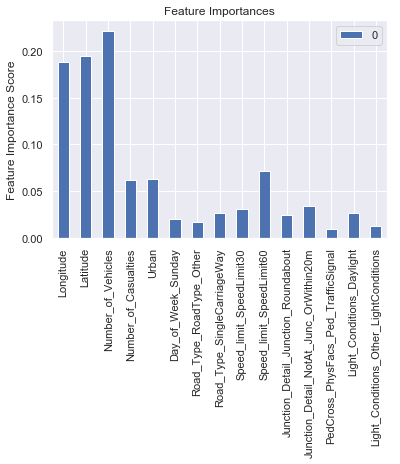

In [77]:
# Feature importances
model=RandomForestClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 4, max_depth = 10, 
                             n_jobs=-1,random_state=321)
model.fit(X_train_rus,y_train_rus)
feat_imp = pd.DataFrame(model.feature_importances_, index=x_kbest.columns)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

# Ensemble method: Bagging

# Voting Classifier

In [ ]:
start=time()

# Tuned Classifiers
knn = KNeighborsClassifier(weights='uniform', n_neighbors=10, leaf_size=1, algorithm='ball_tree',n_jobs=-1)
logit=LogisticRegression(random_state=321)
rfc = RandomForestClassifier(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 4, max_depth = 10, 
                             n_jobs=-1, random_state=321)

# Create the ensemble model
ensemble_clf = VotingClassifier(estimators=[('KNN', knn), ('Logistic Regression', logit), ('Random Forest', rfc)],
                         voting='soft', weights=[1,1,1])

# Define kfold
kfold = model_selection.KFold(n_splits=10, random_state=321)

# Cross-validated accuracy score
accu_test_scores = cross_val_score(ensemble_clf, X_train_rus, y_train_rus, cv=kfold, scoring='accuracy')
print ("Cross-validated accuracy score: %.3f (+/- %.3f)" %(accu_test_scores.mean(), accu_test_scores.std()*2))

# Cros-validated area under ROC curve 
au_roc_scores = cross_val_score(ensemble_clf, X_train_rus, y_train_rus, cv=kfold, scoring='roc_auc')
print ("Cross-validated area under ROC curve: %.3f (+/- %.3f)" %(au_roc_scores.mean(), au_roc_scores.std()*2))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

In [ ]:

# Example
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())

* Fit the estimator on the tuned parameters and get probabilities
* Save those probabilities for each estimator
* Specify range of weights to be 0.1 to 1
* Create a for loop that goes over each probaility and weith combination and spits weighted probaility
* Pick the best weighted combo
* To avoid overfitting, use CV
* 

# Ensemble method: Boosting

# Boosting method 1: Gradient boosting

In [59]:
start=time()
print('Gradient tree boosting\n')
fit_eval_clf(GradientBoostingClassifier(random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

Gradient tree boosting

Cross-validated accuracy score on train samples: 0.611 (+/- 0.011)
Cross-validated area under ROC curve on train samples: 0.649 (+/- 0.014)


Accuracy score on test samples:  0.64
Area under ROC curve score on test samples:  0.61


Total time to run: 1.05 minutes.


# Boosting method 2: Adaptive boosting 

In [60]:
start=time()
print('Adaptive boosting\n')
fit_eval_clf(AdaBoostClassifier(random_state=321))
print('\n')
print("Total time to run: %.2f minutes." % ((time() - start)/60))

Adaptive boosting

Cross-validated accuracy score on train samples: 0.604 (+/- 0.013)
Cross-validated area under ROC curve on train samples: 0.640 (+/- 0.015)


Accuracy score on test samples:  0.63
Area under ROC curve score on test samples:  0.61


Total time to run: 0.44 minutes.


# Boosting method 3: XGBoost

In [61]:
# Convert data to dmatrix for xgboost
data_dmatrix = xgb.DMatrix(data=X_train_rus,label=y_train_rus)

# Parameter sets
params = {"objective":"binary:logistic",'colsample_bytree': 0.8,'learning_rate': 0.01, 'max_depth': 4, 'alpha': 50, 
          'min_child_weight' : 6, 'n_estimators':1000, 'nthread':4, 'scale_pos_weight':1, 'subsample':0.8, 'seed':321,
         'reg_alpha':0.01}

In [62]:
# Cross-validated results
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,num_boost_round=1000,early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=321)

[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[23:01:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

In [63]:
# Print results
print(cv_results.head())
print((cv_results["test-auc-mean"]).tail(1))

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0           0.621          0.013          0.616         0.015
1           0.635          0.002          0.630         0.010
2           0.639          0.002          0.632         0.009
3           0.640          0.002          0.634         0.009
4           0.641          0.002          0.635         0.009
25   0.639
Name: test-auc-mean, dtype: float64


# Ensemble method: Stacking

In [124]:
start=time()

# Stacking Classifier
stacked_clf = StackingClassifier(classifiers=[knn, logit, rfc], meta_classifier=LogisticRegression())

# Stacking classifiers
label = ['KNN', 'Logistic Regression', 'Random Forest', 'Stacking Classifier']
clf_list = [knn, logit, rfc, stacked_clf] 

for clf, label in zip(clf_list, label):
    print(clf)
    accu_test_scores = cross_val_score(clf, X_train_rus, y_train_rus, cv=10, scoring='accuracy')
    print ("Cross-validated accuracy score: %.3f (+/- %.3f)" %(accu_test_scores.mean(), accu_test_scores.std()*2),label)
    
    # Cros-validated area under ROC curve 
    au_roc_scores = cross_val_score(clf, X_train_rus, y_train_rus, cv=10, scoring='roc_auc')
    print ("Cross-validated area under ROC curve:%.3f (+/- %.3f)" %(au_roc_scores.mean(), au_roc_scores.std()*2),label)
    print('\n')
    print("Total time to run: %.2f minutes." % ((time() - start)/60))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
           weights='uniform')
Cross-validated accuracy score: 0.575 (+/- 0.011) KNN
Cross-validated area under ROC curve:0.602 (+/- 0.012) KNN


Total time to run: 0.73 minutes.
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=321, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Cross-validated accuracy score: 0.593 (+/- 0.016) Logistic Regression
Cross-validated area under ROC curve:0.622 (+/- 0.022) Logistic Regression


Total time to run: 0.77 minutes.
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4